# Map to World Coordinates

Rotation and Translation
Now that you have generated a map of navigable terrain in rover-centric coordinates, the next step is to map those points to world coordinates. To do this, you'll use a rotation followed by a translation. The rotation is required to account for the fact that when the camera takes a picture, the rover can be pointing in any arbitrary direction, given by it's yaw angle. The translation is to account for the fact that the rover may be located at any position in the world when it takes a picture. So, it's a 2 step process: 
Rotate the rover-centric coordinates so that the x and y axes are parallel to the axes in world space.
Translate the rotated positions by the x and y position values given by the rover's location (position vector) in the world. 

What we try to achieve is to cpome form the rover specific map generated in the previous step to a world view map.

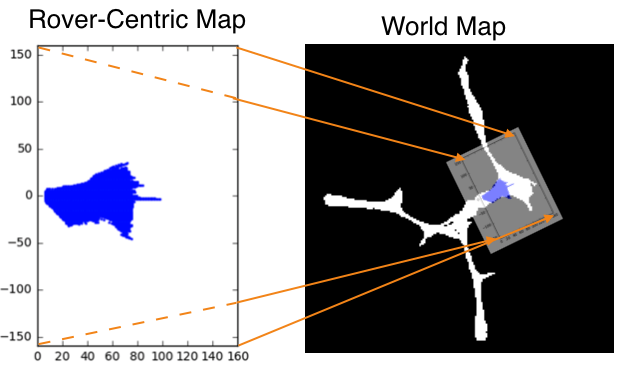

## Rotate the rover-centric coordinates so that the x and y axes are parallel to the axes in world space.

In linear algebra, a rotation matrix is a matrix that is used to perform a rotation in Euclidean space. For example, using the convention below, the matrix

R=\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix} 

rotates points in the xy-Cartesian plane counter-clockwise through an angle θ about the origin of the Cartesian coordinate system. To perform the rotation using a rotation matrix R, the position of each point must be represented by a column vector v, containing the coordinates of the point. A rotated vector is obtained by using the matrix multiplication Rv.

The examples in this article apply to active rotations of vectors counter-clockwise in a right-handed coordinate system by pre-multiplication. If any one of these is changed (e.g. rotating axes instead of vectors, i.e. a passive transformation), then the inverse of the example matrix should be used, which coincides precisely with its transpose.

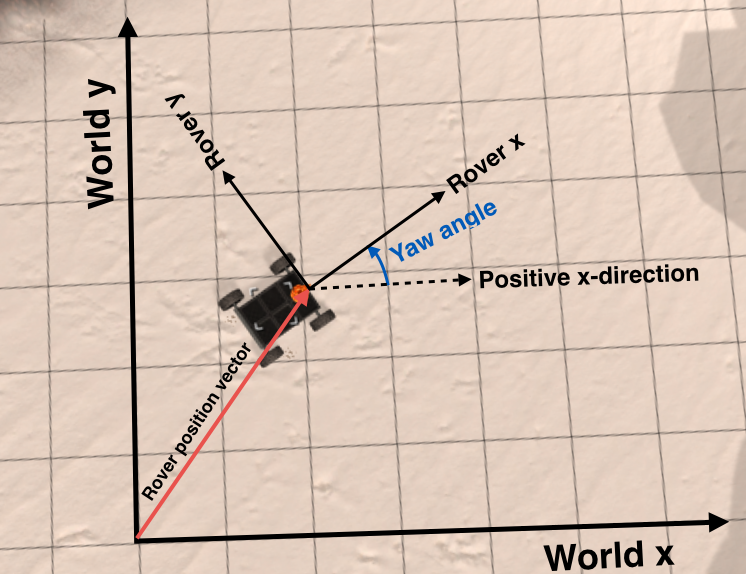

For definition and orientation this is a good reminder image

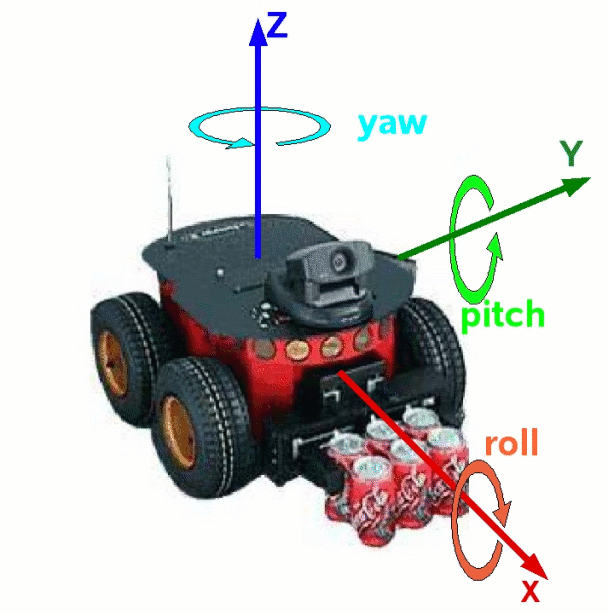

The first task is to perform a rotation. You'll accomplish this by applying a rotation matrix to your rover space pixel values (let's call them xpix and ypix). For a rotation through an angle θ, the operation looks like this:

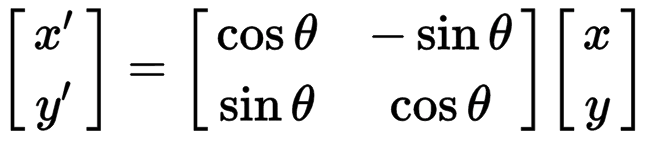

Or written out explicitly it looks like this:

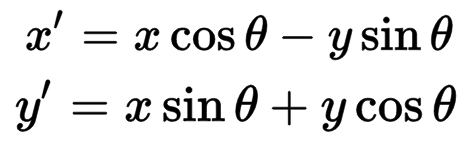

Or in code, you could write it up like this (passing in xpix and ypix as our original pixel positions and yaw as our yaw angle:

#yaw angle is recorded in degrees so first convert to radians
`import numpy as np
yaw_rad = yaw * np.pi / 180
x_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
y_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)`

## Translation

The next step in mapping to world coordinates is to perform a translation by simply adding the x and y components of the rover's position to the x_rotated and y_rotated values calculated above. 
Keep in mind, however, the scale associated with pixels in rover space versus world space. If, for example, as suggested in the previous exercise, you have mapped pixels in rover space such that each represents 0.1 x 0.1 m, and in your world map (as will be the case in the project) each pixel is 1 x 1 m, then you need to divide your rover space pixel values by 10 before mapping to world space. In that case, assuming the x and y position of the rover are given as xpos and ypos:

#Assume a scale factor of 10 between world space pixels and rover space pixels
scale = 10
#Perform translation and convert to integer since pixel values can't be float
`x_world = np.int_(xpos + (x_rotated / scale))
y_world = np.int_(ypos + (y_rotated / scale))`

Ultimately you would like to add these new pixels to your map, but you may have inadvertently generated values that fall outside your map if the rover was near the edge of the world, so you should also truncate the values to be within the allowable range given by the map size using the np.clip() function.

#Assume a mapsize of 200 x 200 pixels (for our 200 x 200 m world)

`world_size = 200
x_pix_world = np.clip(x_world, 0, world_size - 1)
y_pix_world = np.clip(y_world, 0, world_size - 1)`

Xpos = [ 51.97386783] Ypos = [ 137.60757604] Yaw = [ 252.33405338]


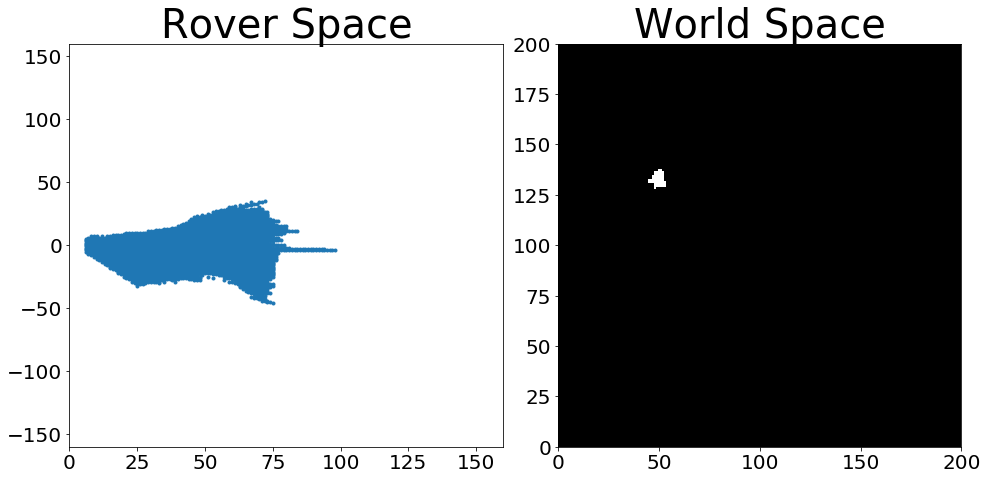

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

#functions from the support functions.py
#------------------------------------------
def perspect_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    dst = np.float32([[img_size[0]/2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - 2*dst_size - bottom_offset], 
                      [img_size[0]/2 - dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      ])
       
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)# keep same size as input image
    return warped

def color_thresh(img, rgb_thresh=(170, 170, 170)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
    
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

#--------------------------------------------------------------------------------------

# Read in the sample image
image = mpimg.imread('sample.jpg')

# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

# Define a function to apply a rotation to pixel positions
# Solution

# Define a function to map rover space pixels to world space

def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# No need to modify code below here
# Perform warping and color thresholding
warped = perspect_transform(image)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show() # Uncomment if running on your local machine